#ViT (Vision Transformer)

##1. Preparación de datos

In [ ]:
## CARGA DE DATOS
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

In [ ]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6016052329430460093]

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 6.0 MB/s 


In [ ]:
!pip install --quiet vit-keras

In [ ]:
from vit_keras import vit

In [ ]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [ ]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models    import Sequential, load_model
from tensorflow.keras.layers    import Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import partial
from tensorflow.keras.regularizers import L2
from sklearn.metrics import classification_report, confusion_matrix

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprime en pantalla el resultado de todos los statements

In [ ]:
## DIRECTORIOS
## =============================================================================

base_dir =  'drive/MyDrive/TFM/ViT/'
train_dir = 'dataset_undersampling/train'
test_dir  = 'dataset_undersampling/test'

In [ ]:
## GENERADOR DE IMÁGENES (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (224, 224),                 
        batch_size  = 32,
        shuffle=True,
        color_mode='rgb',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=True,
        color_mode='rgb',
        class_mode  = 'categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


##2. Implementación de "patches"

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

##3. Modelo Base "Patches" 32x32

In [ ]:
image_size = 224
patch_size = 32

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


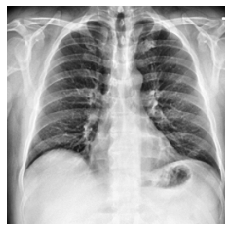

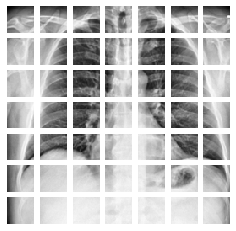

In [ ]:
plt.figure(figsize=(4, 4))

image = train_generator[0][0][0]
plt.imshow(image, interpolation="nearest");
plt.axis("off")

image = np.expand_dims(image, axis=0)
patches = Patches(patch_size)(image)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]));
plt.figure(figsize=(4, 4));
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy(), interpolation="nearest")
    plt.axis("off")
plt.show();

In [ ]:
model = vit.vit_b32(
        image_size = 224,
        activation = 'sigmoid',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        weights = 'imagenet21k',
        classes = 4)

model.summary();

Model: "vit-b32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 7, 7, 768)         2360064   
_________________________________________________________________
reshape_3 (Reshape)          (None, 49, 768)           0         
_________________________________________________________________
class_token (ClassToken)     (None, 50, 768)           768       
_________________________________________________________________
Transformer/posembed_input ( (None, 50, 768)           38400     
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 50, 768), (None,  7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 50, 768), (None,  7087

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================
import tensorflow_addons as tfa
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', 
               optimizer= optimizer,
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'ViT_b32_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=30,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'ViT_b32_history.npy', history.history)

Epoch 1/30
412/412 [==============================] - 398s 820ms/step - loss: 0.5223 - accuracy: 0.8032 - val_loss: 0.2966 - val_accuracy: 0.8938
Epoch 2/30
412/412 [==============================] - 335s 814ms/step - loss: 0.2785 - accuracy: 0.8963 - val_loss: 0.3035 - val_accuracy: 0.9026
Epoch 3/30
412/412 [==============================] - 336s 816ms/step - loss: 0.2186 - accuracy: 0.9201 - val_loss: 0.2567 - val_accuracy: 0.9050
Epoch 4/30
412/412 [==============================] - 335s 814ms/step - loss: 0.1695 - accuracy: 0.9384 - val_loss: 0.2767 - val_accuracy: 0.9075
Epoch 5/30
412/412 [==============================] - 336s 816ms/step - loss: 0.1335 - accuracy: 0.9518 - val_loss: 0.2781 - val_accuracy: 0.9211
Epoch 6/30
412/412 [==============================] - 335s 813ms/step - loss: 0.1283 - accuracy: 0.9539 - val_loss: 0.2909 - val_accuracy: 0.9108
Epoch 7/30
412/412 [==============================] - 335s 812ms/step - loss: 0.0965 - accuracy: 0.9664 - val_loss: 0.3918 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'ViT_b32_model.h5')
history = np.load(base_dir + 'ViT_b32_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

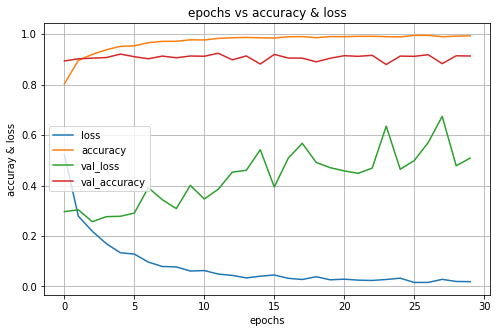

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 25s 242ms/step - loss: 0.5089 - accuracy: 0.9135


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 1, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

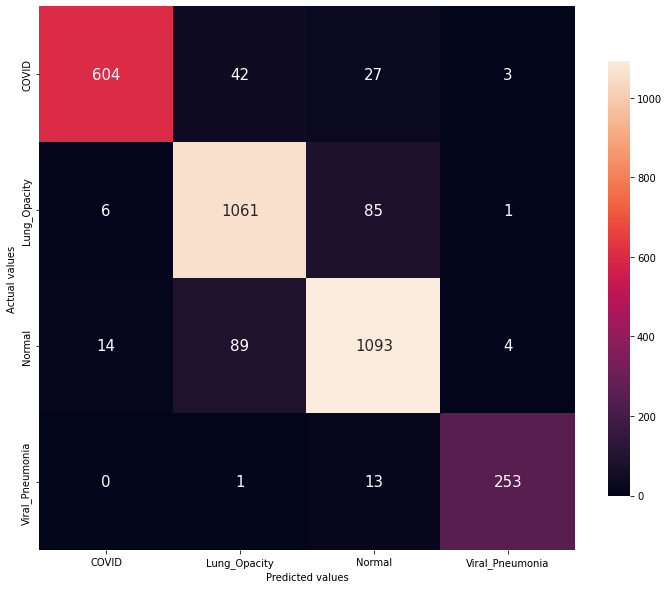

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.97      0.89      0.93       676
   Lung_Opacity       0.89      0.92      0.90      1153
         Normal       0.90      0.91      0.90      1200
Viral_Pneumonia       0.97      0.95      0.96       267

       accuracy                           0.91      3296
      macro avg       0.93      0.92      0.92      3296
   weighted avg       0.91      0.91      0.91      3296



##4. Modelo Base "patches" 16x16

In [ ]:
image_size = 224
patch_size = 16

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


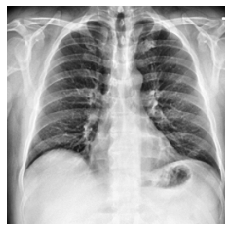

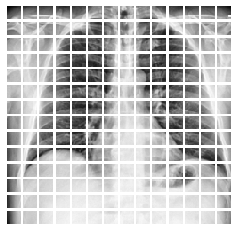

In [ ]:
plt.figure(figsize=(4, 4))

image = train_generator[0][0][0]
plt.imshow(image, interpolation="nearest");
plt.axis("off")

image = np.expand_dims(image, axis=0)
patches = Patches(patch_size)(image)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]));
plt.figure(figsize=(4, 4));
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy(), interpolation="nearest")
    plt.axis("off")
plt.show();

In [ ]:
model = vit.vit_b16(
        image_size = 224,
        activation = 'sigmoid',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        weights = 'imagenet21k',
        classes = 4)

model.summary();

Model: "vit-b16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 14, 14, 768)       590592    
_________________________________________________________________
reshape_1 (Reshape)          (None, 196, 768)          0         
_________________________________________________________________
class_token (ClassToken)     (None, 197, 768)          768       
_________________________________________________________________
Transformer/posembed_input ( (None, 197, 768)          151296    
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 197, 768), (None, 7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 197, 768), (None, 7087

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================
import tensorflow_addons as tfa
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.0001)

model.compile(loss='categorical_crossentropy', 
               optimizer= optimizer,
               metrics=['accuracy'])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'ViT_b16_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=30,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'ViT_b16_history.npy', history.history)

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir +'ViT_model3.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(
                  train_generator,
                  epochs=15,
                  validation_data= test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'ViT_history3.npy', history.history)

Epoch 1/15
412/412 [==============================] - 1182s 3s/step - loss: 0.4567 - accuracy: 0.8233 - val_loss: 0.3173 - val_accuracy: 0.8853
Epoch 2/15
412/412 [==============================] - 1113s 3s/step - loss: 0.2409 - accuracy: 0.9128 - val_loss: 0.3787 - val_accuracy: 0.8714
Epoch 3/15
412/412 [==============================] - 1111s 3s/step - loss: 0.1844 - accuracy: 0.9335 - val_loss: 0.2056 - val_accuracy: 0.9260
Epoch 4/15
412/412 [==============================] - 1098s 3s/step - loss: 0.1431 - accuracy: 0.9477 - val_loss: 0.2096 - val_accuracy: 0.9287
Epoch 5/15
412/412 [==============================] - 1100s 3s/step - loss: 0.1077 - accuracy: 0.9602 - val_loss: 0.2983 - val_accuracy: 0.9147
Epoch 6/15
412/412 [==============================] - 1098s 3s/step - loss: 0.1024 - accuracy: 0.9630 - val_loss: 0.2889 - val_accuracy: 0.9160
Epoch 7/15
412/412 [==============================] - 1099s 3s/step - loss: 0.0728 - accuracy: 0.9740 - val_loss: 0.2601 - val_accuracy:

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'ViT_b16_model.h5')
history = np.load(base_dir + 'ViT_b16_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

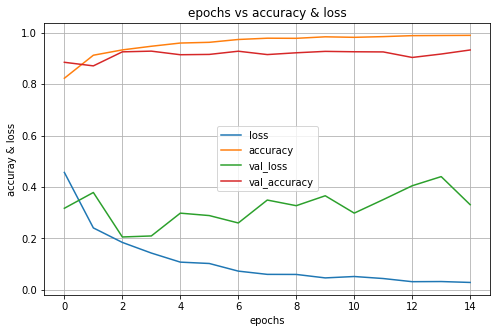

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 79s 768ms/step - loss: 0.3312 - accuracy: 0.9333


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

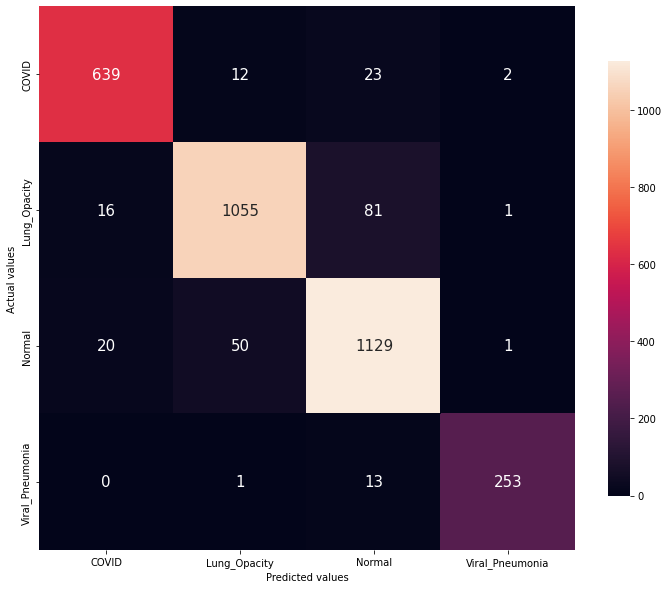

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.95      0.95      0.95       676
   Lung_Opacity       0.94      0.92      0.93      1153
         Normal       0.91      0.94      0.92      1200
Viral_Pneumonia       0.98      0.95      0.97       267

       accuracy                           0.93      3296
      macro avg       0.95      0.94      0.94      3296
   weighted avg       0.93      0.93      0.93      3296



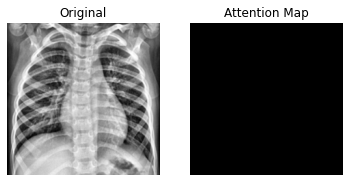

In [ ]:
from vit_keras import visualize

image = test_generator[0][0][0]
attention_map = visualize.attention_map(model = model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

plt.show();